#                                Maternal Health Risk Assesment


# Reasoning Behind Choosing The Dataset
In Bangladesh there are a lot of birth related complicacies that occur in the rural level. Due to the socio economical state of the family, infrastructure and lack of proper access to health care, the country sees around 173 maternal deaths per 100,000 live births in Bangladesh as seen in [World Bank Data](https://data.worldbank.org/indicator/SH.STA.MMRT?locations=BD). Thus we are falling behind from the SDG Goal of reducing the global maternal mortality ratio to 70 deaths per 100,000 live births by 2030. My focus was to find a dataset that generated from the rural areas of Bangladesh, where the variables can be used to group expecting mothers in different risk clusters. This preliminary analysis can be a gateway to create a model that can be used to classify a particular woman in different cluster so that we can decide who should get extra care during the pregancy period thus reducing the chance of mortality during child birth. The Dataset was obtained from the Machine Learning Data Repository of UCI titled [Maternal Health Risk Data Set Data Set](https://archive.ics.uci.edu/ml/datasets/Maternal+Health+Risk+Data+Set).The Data has been collected from different hospitals, community clinics, maternal health cares from the rural areas of Bangladesh through the IoT based risk monitoring system.


# The Problem Goal : Categorizing expecting mothers in Different Risk Clusters

The goal of this notebook analysis is to do some preliminary data analysis to understand the data(Null Value/Class Imbalance etc.), Data Visualization to get insights and Lastly preparing the data for Logistic Regression taught in our course and lastly using scikit-learn's own [logistic regression library](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to cluster the sample data points.


# Dataset Description
Attribute Information:

1. Age: Any ages in years when a women during pregnant.
2. SystolicBP: Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.
3. DiastolicBP: Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.
4. BS: Blood glucose levels is in terms of a molar concentration, mmol/L.
5. HeartRate: A normal resting heart rate in beats per minute.
6. Risk Level: Predicted Risk Intensity Level during pregnancy considering the previous attribute.


# Initial Setup
Run the following code cell to load the utilities used for analysis and visualization 

In [283]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data Loading and Preliminary Analysis
First we will load the dataset which is inside the workspace, then try to see if the data contains any anamoly such as duplicates or null values. 

In [284]:
df=pd.read_csv("Maternal Health Risk Data Set.csv")

In [285]:
display(df)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk


In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


# Comments from .info() 
We can see from the info of the dataset that there are no null values present in the dataset. There are 6 numerical columns and one categorical column which is our dependent/target variable.

# Visualization

We want to see how the data is distributed here. First we will focus on the value distribution of Target variable "Risk Level". After that we will try to find the correlation with the values of risk level with the other attributes such as Age,BloodPressures etc.

<AxesSubplot:xlabel='RiskLevel', ylabel='count'>

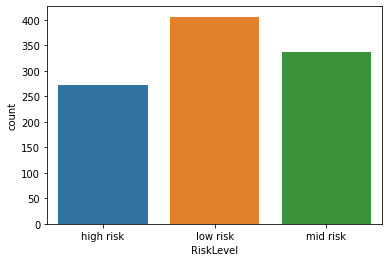

In [287]:
sns.countplot(data=df,x='RiskLevel')

We can see that the risk levels are distributed fairly in an uniform manner with the number of high risk being the lowest.

<AxesSubplot:xlabel='Age', ylabel='Count'>

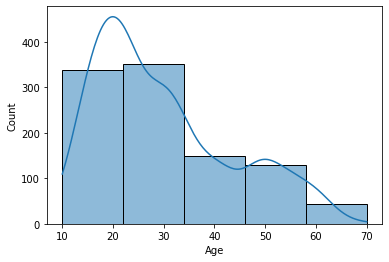

In [288]:
sns.histplot(df['Age'],bins=5,kde=True)

We can see the age distribution is mostly peaks at the age between 15-25. We can see the distribution of the age from the code cell below.

In [289]:
df[df['Age']<75]['Age'].value_counts(bins=10).sort_index()

(9.939, 16.0]    130
(16.0, 22.0]     254
(22.0, 28.0]     162
(28.0, 34.0]     150
(34.0, 40.0]     103
(40.0, 46.0]      42
(46.0, 52.0]      79
(52.0, 58.0]      50
(58.0, 64.0]      39
(64.0, 70.0]       5
Name: Age, dtype: int64

<AxesSubplot:xlabel='BS', ylabel='Age'>

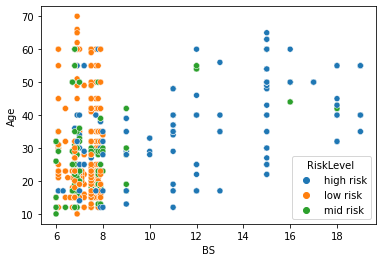

In [290]:
sns.scatterplot(y=df['Age'],x=df['BS'],hue=df['RiskLevel'])

<AxesSubplot:xlabel='RiskLevel', ylabel='HeartRate'>

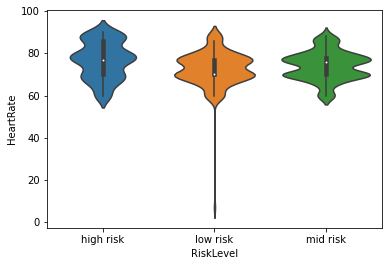

In [291]:
sns.violinplot(data=df,y='HeartRate',x='RiskLevel')

From the above two diagrams , we can see a clear distinction where higher Blood Sugar and Heart Rate leads to greater Risk

# Data Cleaning And Preparation




As for data cleaning and preparation, the categorical values of RiskLevel column needs to be converted to numerical values where high=1, mid=0, low=0. This is done because, the Logistric Regression needs the dependent variable(which in this case is RiskLevel) to be numerical. So we are going to cluster the lables either in 1 or 0.

In [292]:
data_col={'high risk':1,'mid risk':0,'low risk':0}
df['RiskLevel']=df['RiskLevel'].replace(data_col)
set(df['RiskLevel'].values)

{0, 1}

In an earlier cell , we saw that there are birth records where age is between 55-70. These records can be termed as 'outliers' or mistakes. Thus we are going to take average of the age values from 30-70 and replace those values with that mean value.

In [293]:
mean_val=df[(df['Age']>30) & (df['Age']<70)]['Age'].mean()
print("The Mean Value is :{}".format( mean_val))
df.loc[(df['Age']>55) & (df['Age']<70),'Age']=mean_val



The Mean Value is :43.88413098236776


# Logistic Regression

First we will seperate the features and the labels(RiskLevel). We want to keep a certain amount of data separate , which is going to be used for testing purposes. We will choose that number to be 80% of the actual amount of data. 

In [294]:

X=np.insert(df.iloc[:,:-1].values,len(df.columns)-1,1.0,axis=1)
y=df['RiskLevel'].values[:,np.newaxis]
display(X)
display(y)


array([[ 25., 130.,  80., ...,  98.,  86.,   1.],
       [ 35., 140.,  90., ...,  98.,  70.,   1.],
       [ 29.,  90.,  70., ..., 100.,  80.,   1.],
       ...,
       [ 35.,  85.,  60., ...,  98.,  86.,   1.],
       [ 43., 120.,  90., ...,  98.,  70.,   1.],
       [ 32., 120.,  65., ..., 101.,  76.,   1.]])

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [295]:
sample_num=round(len(X)*.8)
print('The original size of the dataset is {}'.format(len(X)))
print('the test sample size is {}'.format(sample_num))
sample_x=X[:sample_num]
sample_y=y[:sample_num]
print('the number of record in sample_x is {} and in sample_y is {}'.format(len(sample_x),len(sample_y)))
#test_num=len(X)-sample_num
test_x=X[sample_num:]
test_y=y[sample_num:]
print('the number of record in test_x is {} and in test_y is {}'.format(len(test_x),len(test_y)))

The original size of the dataset is 1014
the test sample size is 811
the number of record in sample_x is 811 and in sample_y is 811
the number of record in test_x is 203 and in test_y is 203


## Now we will create the sigmoid function, gradient function to get optimal theta values and the linear discriminant function  needed for logisitic regression below. We will also need the log likelihood function that will be required to do the gradient descent evaluation of theta.  

In [296]:
def lin_discr (X, theta):
    y=np.dot(theta.T,X.T)
    return y.T

In [297]:
def logistic(X,theta):
    Y=np.dot(theta.T,X.T)
    G_y=1/(1+np.exp(-Y))
    #print(G_y)
    return G_y

In [298]:
def grad_log_likelihood(theta, y, X):
    s=np.dot(X,theta)
    ina=1/(1+np.exp(-s))
    t=np.dot(X.T,y)-np.dot(X.T,ina)
    return t

In [299]:
def ret_theta(X,y):
    ALPHA = 0.1
    MAX_STEP = 5000

    # Get the data coordinate matrix, X, and labels vector, y
    w = X
    f = y.astype(dtype=float)
    #print(w)
    #print(f)
    record,attribute=w.shape
    #print(attribute)
    #print(X)
    #print(y)

    # Store *all* guesses, for subsequent analysis
    thetas = np.zeros((7, MAX_STEP+1))
    #print(thetas.shape)

    for t in range(MAX_STEP):
        # Fill in the code to compute thetas[:, t+1:t+2]
        theta_last = thetas[:, t:t+1]
        gradient = grad_log_likelihood(theta_last, f, w)
        step = ALPHA * (gradient / (np.linalg.norm(gradient, ord=None)))
        update = theta_last + step
        #print(update)
        thetas[:, t+1:t+2] = update
    
    op_theta=thetas[:,MAX_STEP]
    
    #print(op_theta)
    return op_theta
        # Fill in the code to compute thetas[:, t+1:t+2]
        ###
        ### YOUR CODE HERE
        ###

In [300]:
thetas=ret_theta(sample_x,sample_y)

In [301]:
print('The values of thetas are {}'.format(thetas))

The values of thetas are [-0.040346    0.02304309  0.03476693  0.75257299 -0.17177448  0.07367455
 -0.05128863]


In [302]:
def log_heav(Y):
    return [1 if i >= 0.5 else 0 for i in Y]
def heaviside(Y):
    s=np.heaviside(Y,0)
    return s
    
def heaviside_int(Y):
    """Evaluates the heaviside function, but returns integer values."""
    return heaviside(Y).astype(dtype=int)

def gen_lin_discr_labels(points, theta, fun=heaviside_int):
    """
    Given a set of points and the coefficients of a linear
    discriminant, this function returns a set of labels for
    the points with respect to this discriminant.
    """
    score = lin_discr(points, theta)
    labels = fun(score)
    return labels



In [303]:
test_labels_log=gen_lin_discr_labels(test_x,thetas,log_heav)
test_lables_linear=gen_lin_discr_labels(test_x,thetas)


In [304]:
def get_accuracy(y_pred, y):
    
    assert len(y_pred) == len(y)
    n = len(y)
    Y = y
    
    count = 0
    for i in range(n):
        if y_pred[i] == Y[i]:
            count+=1
     
    return round(((count/n)*100),2)

In [305]:
acc=get_accuracy(test_lables_linear,test_y.T.flatten())
acc_log=get_accuracy(test_labels_log,test_y.T.flatten())
print('The accuracy with linear discriminant is {}'.format(acc))
print('The accuracy with logistic discriminant is {}'.format(acc_log))

The accuracy with linear discriminant is 85.22
The accuracy with logistic discriminant is 84.24


# Using sklearn's native logistic regression library to compare

In [306]:
from sklearn.model_selection import train_test_split

In [307]:
X_1=df.iloc[:,:-1]
y_1=df.iloc[:,-1]


In [308]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X_1, y_1, test_size=0.33, random_state=42)

In [309]:
from sklearn.linear_model import LogisticRegression

In [310]:
linmodel = LogisticRegression(solver='liblinear')
logmodel=LogisticRegression(multi_class='multinomial')
lin_fit=linmodel.fit(X1_train,y1_train)
log_fit=logmodel.fit(X1_train,y1_train)


In [311]:
predictions_lin = linmodel.predict(X1_test)
predictions_log = logmodel.predict(X1_test)

In [312]:
from sklearn.metrics import accuracy_score

In [313]:
print("the accuracy when using the linear discriminant model from the sklearn library is {}".format( accuracy_score(y1_test,predictions_lin)))
print("the accuracy when using the logistic discriminant model from the sklearn library is {}".format( accuracy_score(y1_test,predictions_log)))

the accuracy when using the linear discriminant model from the sklearn library is 0.8597014925373134
the accuracy when using the logistic discriminant model from the sklearn library is 0.8388059701492537
